### In this hands-on you will be using pretrained yolo model for object detection.
#### Follow thr instructions provided for each cell and code accordingly.
#### Press shift + enter to run the in each cell and make sure you do this for all the cells in the notebook.

### Run the below cell to import all necessary packages required for this hands-on

In [1]:
!alias python=python3
!alias pip=pip3
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from keras.models import load_model, Model
from keras import backend as K
import tensorflow as tf

from utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body


Using TensorFlow backend.


In [2]:
# download weights file
!curl -O https://pjreddie.com/media/files/yolov2-tiny-voc.weights 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60.5M  100 60.5M    0     0   254k      0  0:04:03  0:04:03 --:--:--  224k


In [3]:
!python3 yad2k.py yolo_tiny.cfg yolov2-tiny-voc.weights model_data/yolo_tiny.h5

Using TensorFlow backend.
Loading weights.
Weights Header:  [      0       1       0 2566400]
Parsing Darknet config.
Creating Keras model.
Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 16)
2020-12-17 09:22:27.828021: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
Parsing section maxpool_0
Parsing section convolutional_1
conv2d bn leaky (3, 3, 16, 32)
Parsing section maxpool_1
Parsing section convolutional_2
conv2d bn leaky (3, 3, 32, 64)
Parsing section maxpool_2
Parsing section convolutional_3
conv2d bn leaky (3, 3, 64, 128)
Parsing section maxpool_3
Parsing section convolutional_4
conv2d bn leaky (3, 3, 128, 256)
Parsing section maxpool_4
Parsing section convolutional_5
conv2d bn leaky (3, 3, 256, 512)
Parsing section maxpool_5
Parsing section convolutional_6
conv2d bn leaky (3, 3, 512, 1024)
2020-12-17 09:22:29.380594: W tensorflow/core/framew

#### compute box_scores by multiplying box_confidence and box_class_probs  
#### extracts class indices of maximum score and their corresponding score values and assign it to variable box_classes and box_class_scores  
#### filter out the box_scores above a threshold, and return the corresponding scores, boxe dimensions and their classes.

In [18]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.6):
    
    
    box_scores =box_confidence*box_class_probs
#     print(box_confidence)
#     print(boxes)
#     print(box_class_probs)
#     print( box_scores)
    from keras import backend as K 
    box_classes = K.argmax(box_scores,  axis = -1)
    box_class_scores =K.max(box_scores,  axis = -1)
    
    
    
    filtering_mask = (box_class_scores > threshold)
    
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

#### Run the below cell to test the function defined above
### Expected output:
scores[2] = 18.66819   
boxes[2] = [ 1.9018091 -3.9903622 -4.009363  -3.981121 ]  
classes[2] = 21  
scores.shape = (?,)  
boxes.shape = (?, 4)  
classes.shape = (?,)  


In [19]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 51)
    boxes = tf.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 51)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 51)
    
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))

scores[2] = 18.66819
boxes[2] = [-0.40550387  1.6398532  -1.2696881   1.3711817 ]
classes[2] = 21
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)


#### Define the function yolo_non_max_supression to implement nonmax suppression to eliminate overlapping boxes.



In [21]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    
    
    max_boxes_tensor = K.variable(max_boxes, dtype = 'int32')   # tensor to be used in tf.image.non_max_suppression()
    
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    
    nms_indices =  tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold)
    ###use tf.image.non_max_suppression to extract eliminate ovelapping boxes
    ####Use tf.gather() to pick boxes and their respective predicted classes as well as their scores
    scores =  tf.gather(scores, nms_indices)         
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    
    
    return scores, boxes, classes

#### Run the below cell to validate the function defined above  
#### Expected output
scores[2] = 7.2168345  
boxes[2] = [  1.3835918  -2.2073252   2.5128307 -10.085559 ]  
classes[2] = -5.1675873  
scores.shape = (10,)  
boxes.shape = (10, 4)  
classes.shape = (10,)  

In [22]:
with tf.Session() as test_b:
    scores = tf.random_normal([54,], mean=1, stddev=4, seed = 51)
    boxes = tf.random_normal([54, 4], mean=1, stddev=4, seed = 51)
    classes = tf.random_normal([54,], mean=1, stddev=4, seed = 51)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    init=tf.global_variables_initializer()
    test_b.run(init)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

    

scores[2] = 7.2168345
boxes[2] = [  1.3835918  -2.2073252   2.5128307 -10.085559 ]
classes[2] = -5.1675873
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


#### Define the function yolo_eval that consolidates all the function defined above to extract single prediction boxes for each object

In [24]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=5, score_threshold=.6, iou_threshold=.5):
    
    box_xy, box_wh,  box_confidence, box_class_probs = yolo_outputs   
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    scores, boxes, classes =yolo_filter_boxes(box_confidence, boxes, box_class_probs,score_threshold)    ###call yolo_filter_boxes to extract box confidence scores
    
    ### the scale_box function adjest the box dimensions according to the image.
    boxes = scale_boxes(boxes, image_shape)  

    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes,max_boxes,iou_threshold)  ### call yolo_non_max_suppression to eliminate overlapping boxes
    return scores, boxes, classes

#### Run the below cell to vlidate yolo_eval function defined above
#### Expected output
scores[2] = 155.1541  
boxes[2] = [   109.86103  -5404.5874     329.5831  -16213.762  ]  
classes[2] = 16  
scores.shape = (5,)  
boxes.shape = (5, 4)  
classes.shape = (5,)  



In [25]:
with tf.Session() as test_b:
    yolo_outputs = (tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 51),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 51),
                    tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 51),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 51))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    init=tf.global_variables_initializer()
    test_b.run(init)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))


scores[2] = 155.1541
boxes[2] = [   109.86103  -5404.5874     329.5831  -16213.762  ]
classes[2] = 16
scores.shape = (5,)
boxes.shape = (5, 4)
classes.shape = (5,)


#### Run the below cell to load the model 

In [26]:
sess = K.get_session()
class_names = read_classes("model_data/pascal_classes.txt")
anchors = read_anchors("model_data/yolo_tiny_anchors.txt")
image_shape = (375., 500.)
yolo_model = load_model("model_data/yolo_tiny.h5")
yolo_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 416, 416, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 416, 416, 16)      432       
_________________________________________________________________
batch_normalization_1 (Batch (None, 416, 416, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 416, 416, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 208, 208, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 208, 208, 32)      4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 208, 208, 32)      128       
__________

/home/user/.local/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Extract predictions

In [28]:

yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names)) #### yolo_head() return box scores, dimensions and claases for each grid cell
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape) ### Filter boxes

#### The method to compute the prediction on an image file has been define for you

In [29]:
def predict(sess, image_file):
   

    image, image_data = preprocess_image(image_file, model_image_size = (416, 416))


    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})
    

    
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))

    colors = generate_colors(class_names)
    
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    
    image.save(os.path.join("out", image_file), quality=90)
    
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

### Run the below cell to detect objects on an image file

Found 2 boxes for men.JPEG
person 0.73 (32, 57) (179, 217)
person 0.84 (218, 26) (337, 286)


/home/user/.local/lib/python3.5/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


(array([0.8387335 , 0.72645026], dtype=float32),
 array([[ 25.513239, 218.34245 , 285.71967 , 427.92056 ],
        [ 57.465282,  32.01086 , 217.19899 , 179.42023 ]], dtype=float32),
 array([14, 14]))

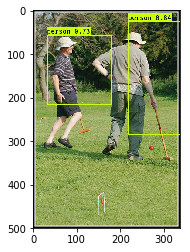

In [30]:
predict(sess, "men.JPEG")